In [1]:
!pip install opendatasets --upgrade --quiet

In [2]:
# Import the OpenDatasets library for dataset downloading
import opendatasets as od

# Specify the URL of the anime face dataset on Kaggle
dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'

# Download the dataset using OpenDatasets library
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  arjuntd


Your Kaggle Key:

  ········


Dataset URL: https://www.kaggle.com/datasets/splcher/animefacedataset


100%|██████████| 395M/395M [00:00<00:00, 1.23GB/s]


In [3]:
# Import the os module for directory manipulation
import os

# Specify the path to the downloaded anime face dataset
DATA_DIR = './animefacedataset'

# Print the list of files and directories in the dataset directory
print(os.listdir(DATA_DIR))


['images']


In [4]:
# Print the list of the first 10 files in the 'images' subdirectory of the dataset
print(os.listdir(os.path.join(DATA_DIR, 'images'))[:10])


['54416_2016.jpg', '8876_2004.jpg', '33694_2011.jpg', '39977_2012.jpg', '25773_2009.jpg', '19645_2007.jpg', '29776_2010.jpg', '37505_2012.jpg', '43067_2013.jpg', '8402_2004.jpg']


In [5]:
# Import necessary modules for data loading and transformations
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T


In [6]:
# Define image size, batch size, and image statistics for normalization
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)


In [7]:
# Create the training dataset using ImageFolder and apply transformations
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

# Create a DataLoader for the training dataset
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)


In [8]:
# Import necessary modules for visualization
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline


In [9]:
def denorm(img_tensors):
    """
    Denormalize the input image tensors.

    Parameters:
        - img_tensors (torch.Tensor): Normalized image tensors.

    Returns:
        - torch.Tensor: Denormalized image tensors.
    """
    return img_tensors * stats[1][0] + stats[0][0]


In [10]:
def show_images(images, nmax=64):
    """
    Display a grid of denormalized images.

    Parameters:
        - images (torch.Tensor): Tensor of images to be displayed.
        - nmax (int): Maximum number of images to display (default: 64).
    """
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    """
    Display a batch of images from the given DataLoader.

    Parameters:
        - dl (torch.utils.data.DataLoader): DataLoader containing the images.
        - nmax (int): Maximum number of images to display (default: 64).
    """
    for images, _ in dl:
        show_images(images, nmax)
        break


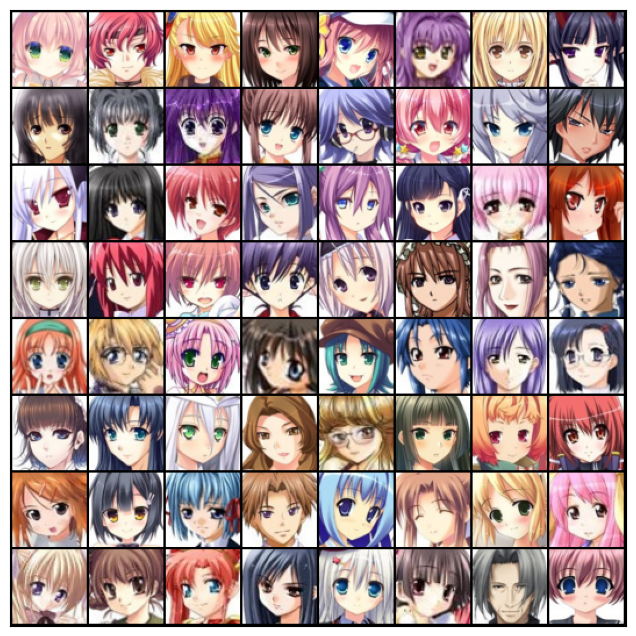

In [11]:
# Display a batch of images from the training DataLoader
show_batch(train_dl)


In [12]:
def get_default_device():
    """
    Pick GPU if available, else CPU.

    Returns:
        - torch.device: Chosen device.
    """
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """
    Move tensor(s) to the chosen device.

    Parameters:
        - data: Input tensor or list/tuple of tensors.
        - device (torch.device): Target device.

    Returns:
        - Tensor or list/tuple of tensors on the specified device.
    """
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """
    Wrap a DataLoader to move data to a device.

    Parameters:
        - dl (torch.utils.data.DataLoader): DataLoader to be wrapped.
        - device (torch.device): Target device.
    """
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to the device."""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches."""
        return len(self.dl)


In [13]:
# Get the default device (GPU if available, else CPU)
device = get_default_device()
device


device(type='cuda')

In [14]:
# Wrap the training DataLoader with DeviceDataLoader to move data to the specified device
train_dl = DeviceDataLoader(train_dl, device)


In [15]:
# Import the torch.nn module for neural network components
import torch.nn as nn


In [16]:
# Define the discriminator model using a sequential architecture
discriminator = nn.Sequential(
    # in: 3 x 64 x 64
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),  # Convolutional layer 1
    nn.BatchNorm2d(64),  # Batch normalization 1
    nn.LeakyReLU(0.2, inplace=True),  # Leaky ReLU activation 1
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),  # Convolutional layer 2
    nn.BatchNorm2d(128),  # Batch normalization 2
    nn.LeakyReLU(0.2, inplace=True),  # Leaky ReLU activation 2
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),  # Convolutional layer 3
    nn.BatchNorm2d(256),  # Batch normalization 3
    nn.LeakyReLU(0.2, inplace=True),  # Leaky ReLU activation 3
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),  # Convolutional layer 4
    nn.BatchNorm2d(512),  # Batch normalization 4
    nn.LeakyReLU(0.2, inplace=True),  # Leaky ReLU activation 4
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),  # Convolutional layer 5 (output layer)
    # out: 1 x 1 x 1

    nn.Flatten(),  # Flatten the output
    nn.Sigmoid()  # Sigmoid activation to produce a probability score
)


In [17]:
# Move the discriminator model to the specified device
discriminator = to_device(discriminator, device)


In [18]:
# Define the size of the latent space for the generator
latent_size = 128


In [19]:
# Define the generator model using a sequential architecture
generator = nn.Sequential(
    # in: latent_size x 1 x 1
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),  # Deconvolutional layer 1
    nn.BatchNorm2d(512),  # Batch normalization 1
    nn.ReLU(True),  # ReLU activation 1
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),  # Deconvolutional layer 2
    nn.BatchNorm2d(256),  # Batch normalization 2
    nn.ReLU(True),  # ReLU activation 2
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),  # Deconvolutional layer 3
    nn.BatchNorm2d(128),  # Batch normalization 3
    nn.ReLU(True),  # ReLU activation 3
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),  # Deconvolutional layer 4
    nn.BatchNorm2d(64),  # Batch normalization 4
    nn.ReLU(True),  # ReLU activation 4
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),  # Deconvolutional layer 5 (output layer)
    nn.Tanh()  # Tanh activation to produce the final image
    # out: 3 x 64 x 64
)


torch.Size([128, 3, 64, 64])


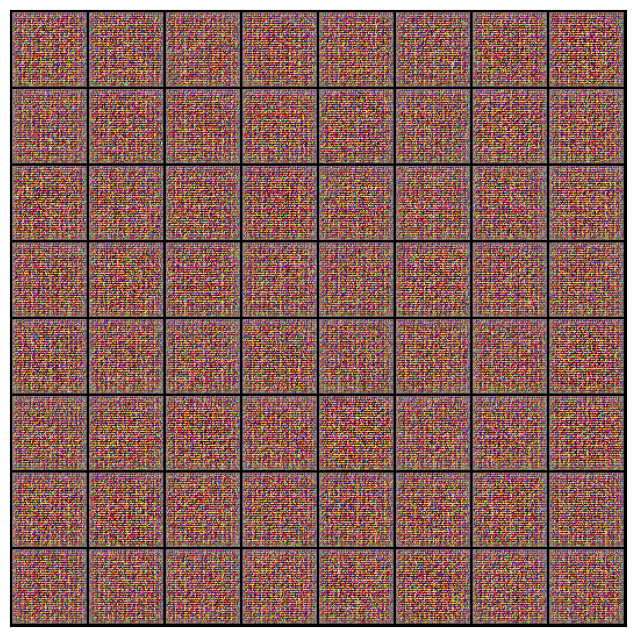

In [20]:
# Generate random latent tensors and use the generator to create fake images
xb = torch.randn(batch_size, latent_size, 1, 1)  # Random latent tensors
fake_images = generator(xb)
print(fake_images.shape)

# Display the generated fake images
show_images(fake_images)


In [21]:
# Move the generator model to the specified device
generator = to_device(generator, device)


In [22]:
def train_discriminator(real_images, opt_d):
    """
    Train the discriminator using real and fake images.

    Parameters:
        - real_images (torch.Tensor): Batch of real images.
        - opt_d (torch.optim.Optimizer): Discriminator optimizer.

    Returns:
        - Tuple (float, float, float): Discriminator loss, real score, fake score.
    """
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()


    return loss.item(), real_score, fake_score

In [23]:
def train_generator(opt_g):
    """
    Train the generator to fool the discriminator.

    Parameters:
        - opt_g (torch.optim.Optimizer): Generator optimizer.

    Returns:
        - float: Generator loss.
    """
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()


In [24]:
# Import the save_image function from torchvision.utils
from torchvision.utils import save_image


In [25]:
# Specify the directory for saving generated images and create it if it doesn't exist
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)


In [26]:
def save_samples(index, latent_tensors, show=True):
    """
    Generate fake images using the generator and save them.

    Parameters:
        - index (int): Index for naming the saved image file.
        - latent_tensors (torch.Tensor): Latent tensors for generating fake images.
        - show (bool): Whether to display the generated images (default: True).
    """
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))


In [27]:
# Generate fixed latent tensors for consistent sample generation
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


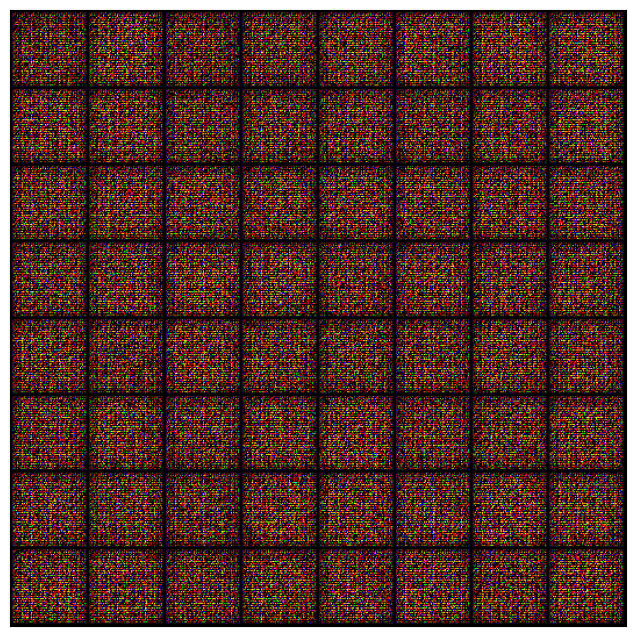

In [28]:
# Save and display generated samples using the fixed latent tensors
save_samples(0, fixed_latent)


In [29]:
# Import necessary modules for progress tracking and functional operations
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [30]:
def fit(epochs, lr, start_idx=1):
    """
    Train the GAN model for a specified number of epochs.

    Parameters:
        - epochs (int): Number of training epochs.
        - lr (float): Learning rate for both discriminator and generator.
        - start_idx (int): Index to start naming the saved images (default: 1).

    Returns:
        - Tuple (list, list, list, list): Generator losses, discriminator losses, real scores, fake scores.
    """
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores


In [31]:
# Set learning rate and number of training epochs
lr = 0.0002
epochs = 100

In [32]:
# Train the GAN model and store the training history
history = fit(epochs, lr)


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/100], loss_g: 3.6534, loss_d: 0.3206, real_score: 0.8583, fake_score: 0.1259
Saving generated-images-0001.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/100], loss_g: 2.7800, loss_d: 0.7330, real_score: 0.5779, fake_score: 0.0147
Saving generated-images-0002.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/100], loss_g: 6.5268, loss_d: 0.2521, real_score: 0.9660, fake_score: 0.1853
Saving generated-images-0003.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/100], loss_g: 7.4691, loss_d: 0.2310, real_score: 0.9468, fake_score: 0.1523
Saving generated-images-0004.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/100], loss_g: 7.0070, loss_d: 1.2056, real_score: 0.4633, fake_score: 0.0003
Saving generated-images-0005.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/100], loss_g: 6.9193, loss_d: 0.3460, real_score: 0.7811, fake_score: 0.0001
Saving generated-images-0006.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/100], loss_g: 12.1842, loss_d: 0.2772, real_score: 0.9917, fake_score: 0.2210
Saving generated-images-0007.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/100], loss_g: 7.2670, loss_d: 0.0784, real_score: 0.9820, fake_score: 0.0567
Saving generated-images-0008.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/100], loss_g: 6.4541, loss_d: 0.0864, real_score: 0.9395, fake_score: 0.0147
Saving generated-images-0009.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/100], loss_g: 6.3152, loss_d: 0.0790, real_score: 0.9542, fake_score: 0.0121
Saving generated-images-0010.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [11/100], loss_g: 7.1157, loss_d: 0.0624, real_score: 0.9507, fake_score: 0.0046
Saving generated-images-0011.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [12/100], loss_g: 11.1247, loss_d: 0.2009, real_score: 0.9678, fake_score: 0.1370
Saving generated-images-0012.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [13/100], loss_g: 5.6048, loss_d: 0.0353, real_score: 0.9873, fake_score: 0.0215
Saving generated-images-0013.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [14/100], loss_g: 6.2292, loss_d: 0.0570, real_score: 0.9955, fake_score: 0.0498
Saving generated-images-0014.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [15/100], loss_g: 5.8448, loss_d: 5.4188, real_score: 0.0813, fake_score: 0.0000
Saving generated-images-0015.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [16/100], loss_g: 5.5274, loss_d: 0.0876, real_score: 0.9406, fake_score: 0.0064
Saving generated-images-0016.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [17/100], loss_g: 4.6257, loss_d: 0.0579, real_score: 0.9657, fake_score: 0.0199
Saving generated-images-0017.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [18/100], loss_g: 8.8339, loss_d: 0.0338, real_score: 0.9781, fake_score: 0.0041
Saving generated-images-0018.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [19/100], loss_g: 5.5661, loss_d: 0.1556, real_score: 0.9115, fake_score: 0.0360
Saving generated-images-0019.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [20/100], loss_g: 15.8409, loss_d: 0.3226, real_score: 0.9999, fake_score: 0.2108
Saving generated-images-0020.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [21/100], loss_g: 9.6796, loss_d: 0.0480, real_score: 0.9817, fake_score: 0.0260
Saving generated-images-0021.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [22/100], loss_g: 7.5607, loss_d: 0.0651, real_score: 0.9636, fake_score: 0.0099
Saving generated-images-0022.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [23/100], loss_g: 9.3605, loss_d: 0.1984, real_score: 0.9613, fake_score: 0.1315
Saving generated-images-0023.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [24/100], loss_g: 6.7807, loss_d: 0.0335, real_score: 0.9809, fake_score: 0.0131
Saving generated-images-0024.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [25/100], loss_g: 10.9719, loss_d: 0.1906, real_score: 0.9780, fake_score: 0.1353
Saving generated-images-0025.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [26/100], loss_g: 6.2127, loss_d: 0.0599, real_score: 0.9724, fake_score: 0.0285
Saving generated-images-0026.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [27/100], loss_g: 23.2190, loss_d: 0.9850, real_score: 0.6259, fake_score: 0.0000
Saving generated-images-0027.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [28/100], loss_g: 8.6223, loss_d: 1.8949, real_score: 0.3659, fake_score: 0.0000
Saving generated-images-0028.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [29/100], loss_g: 25.3819, loss_d: 0.2614, real_score: 0.9997, fake_score: 0.1707
Saving generated-images-0029.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [30/100], loss_g: 4.6645, loss_d: 0.2002, real_score: 0.8539, fake_score: 0.0034
Saving generated-images-0030.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [31/100], loss_g: 6.6132, loss_d: 0.0242, real_score: 0.9906, fake_score: 0.0143
Saving generated-images-0031.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [32/100], loss_g: 6.6261, loss_d: 0.1644, real_score: 0.9035, fake_score: 0.0020
Saving generated-images-0032.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [33/100], loss_g: 6.8324, loss_d: 0.0290, real_score: 0.9783, fake_score: 0.0042
Saving generated-images-0033.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [34/100], loss_g: 19.4401, loss_d: 0.0689, real_score: 0.9475, fake_score: 0.0001
Saving generated-images-0034.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [35/100], loss_g: 12.7313, loss_d: 0.0002, real_score: 0.9999, fake_score: 0.0000
Saving generated-images-0035.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [36/100], loss_g: 5.0371, loss_d: 0.0394, real_score: 0.9729, fake_score: 0.0093
Saving generated-images-0036.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [37/100], loss_g: 23.1932, loss_d: 0.3024, real_score: 0.9993, fake_score: 0.1827
Saving generated-images-0037.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [38/100], loss_g: 5.0549, loss_d: 0.0694, real_score: 0.9585, fake_score: 0.0220
Saving generated-images-0038.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [39/100], loss_g: 6.5890, loss_d: 0.0326, real_score: 0.9906, fake_score: 0.0222
Saving generated-images-0039.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [40/100], loss_g: 28.7979, loss_d: 0.1956, real_score: 0.9943, fake_score: 0.1406
Saving generated-images-0040.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [41/100], loss_g: 13.9005, loss_d: 0.0436, real_score: 0.9686, fake_score: 0.0004
Saving generated-images-0041.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [42/100], loss_g: 31.8442, loss_d: 0.1352, real_score: 0.9985, fake_score: 0.0572
Saving generated-images-0042.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [43/100], loss_g: 6.2954, loss_d: 0.0450, real_score: 0.9880, fake_score: 0.0316
Saving generated-images-0043.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [44/100], loss_g: 5.6446, loss_d: 0.0277, real_score: 0.9821, fake_score: 0.0084
Saving generated-images-0044.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [45/100], loss_g: 5.9314, loss_d: 0.0248, real_score: 0.9834, fake_score: 0.0071
Saving generated-images-0045.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [46/100], loss_g: 8.1952, loss_d: 0.0410, real_score: 0.9949, fake_score: 0.0343
Saving generated-images-0046.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [47/100], loss_g: 17.4571, loss_d: 0.0914, real_score: 0.9499, fake_score: 0.0041
Saving generated-images-0047.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [48/100], loss_g: 7.2979, loss_d: 0.0392, real_score: 0.9880, fake_score: 0.0255
Saving generated-images-0048.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [49/100], loss_g: 4.0654, loss_d: 0.0520, real_score: 0.9670, fake_score: 0.0102
Saving generated-images-0049.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [50/100], loss_g: 9.1243, loss_d: 0.0506, real_score: 0.9927, fake_score: 0.0336
Saving generated-images-0050.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [51/100], loss_g: 22.6845, loss_d: 0.0448, real_score: 0.9979, fake_score: 0.0399
Saving generated-images-0051.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [52/100], loss_g: 8.5099, loss_d: 0.0229, real_score: 0.9998, fake_score: 0.0214
Saving generated-images-0052.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [53/100], loss_g: 5.5423, loss_d: 0.0189, real_score: 0.9963, fake_score: 0.0138
Saving generated-images-0053.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [54/100], loss_g: 10.0376, loss_d: 0.0031, real_score: 0.9975, fake_score: 0.0006
Saving generated-images-0054.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [55/100], loss_g: 4.8884, loss_d: 0.0325, real_score: 0.9873, fake_score: 0.0139
Saving generated-images-0055.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [56/100], loss_g: 7.2834, loss_d: 0.0217, real_score: 0.9846, fake_score: 0.0046
Saving generated-images-0056.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [57/100], loss_g: 42.2578, loss_d: 0.0005, real_score: 0.9995, fake_score: 0.0000
Saving generated-images-0057.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [58/100], loss_g: 6.9566, loss_d: 0.0140, real_score: 0.9947, fake_score: 0.0083
Saving generated-images-0058.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [59/100], loss_g: 7.9974, loss_d: 0.0174, real_score: 0.9846, fake_score: 0.0004
Saving generated-images-0059.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [60/100], loss_g: 8.2066, loss_d: 0.0082, real_score: 0.9964, fake_score: 0.0045
Saving generated-images-0060.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [61/100], loss_g: 29.9354, loss_d: 0.0292, real_score: 0.9815, fake_score: 0.0000
Saving generated-images-0061.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [62/100], loss_g: 15.8177, loss_d: 0.0327, real_score: 0.9876, fake_score: 0.0041
Saving generated-images-0062.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [63/100], loss_g: 26.0650, loss_d: 0.0004, real_score: 1.0000, fake_score: 0.0004
Saving generated-images-0063.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [64/100], loss_g: 7.4967, loss_d: 0.0208, real_score: 0.9975, fake_score: 0.0179
Saving generated-images-0064.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [65/100], loss_g: 8.0040, loss_d: 0.0581, real_score: 0.9593, fake_score: 0.0025
Saving generated-images-0065.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [66/100], loss_g: 3.4879, loss_d: 0.1245, real_score: 0.9306, fake_score: 0.0107
Saving generated-images-0066.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [67/100], loss_g: 13.9331, loss_d: 0.1026, real_score: 0.9981, fake_score: 0.0927
Saving generated-images-0067.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [68/100], loss_g: 26.8190, loss_d: 0.1518, real_score: 0.9423, fake_score: 0.0000
Saving generated-images-0068.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [69/100], loss_g: 10.5925, loss_d: 0.0278, real_score: 0.9824, fake_score: 0.0037
Saving generated-images-0069.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [70/100], loss_g: 8.2579, loss_d: 0.0466, real_score: 0.9689, fake_score: 0.0058
Saving generated-images-0070.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [71/100], loss_g: 8.9591, loss_d: 0.0567, real_score: 0.9824, fake_score: 0.0365
Saving generated-images-0071.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [72/100], loss_g: 52.0507, loss_d: 0.0053, real_score: 0.9956, fake_score: 0.0000
Saving generated-images-0072.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [73/100], loss_g: 40.4891, loss_d: 0.0059, real_score: 0.9951, fake_score: 0.0000
Saving generated-images-0073.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [74/100], loss_g: 5.4553, loss_d: 0.0192, real_score: 0.9838, fake_score: 0.0018
Saving generated-images-0074.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [75/100], loss_g: 8.2503, loss_d: 0.0059, real_score: 0.9979, fake_score: 0.0037
Saving generated-images-0075.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [76/100], loss_g: 6.1975, loss_d: 0.0643, real_score: 0.9999, fake_score: 0.0473
Saving generated-images-0076.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [77/100], loss_g: 5.8928, loss_d: 0.0124, real_score: 0.9996, fake_score: 0.0119
Saving generated-images-0077.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [78/100], loss_g: 17.9694, loss_d: 0.0096, real_score: 0.9990, fake_score: 0.0084
Saving generated-images-0078.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [79/100], loss_g: 13.3320, loss_d: 0.0022, real_score: 0.9986, fake_score: 0.0008
Saving generated-images-0079.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [80/100], loss_g: 9.0690, loss_d: 0.0594, real_score: 0.9579, fake_score: 0.0042
Saving generated-images-0080.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [81/100], loss_g: 7.3321, loss_d: 0.0147, real_score: 0.9886, fake_score: 0.0021
Saving generated-images-0081.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [82/100], loss_g: 62.5721, loss_d: 0.0001, real_score: 0.9999, fake_score: 0.0000
Saving generated-images-0082.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [83/100], loss_g: 62.8986, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0083.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [84/100], loss_g: 62.9477, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0084.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [85/100], loss_g: 63.1145, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0085.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [86/100], loss_g: 62.5517, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0086.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [87/100], loss_g: 62.3375, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0087.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [88/100], loss_g: 61.9395, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0088.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [89/100], loss_g: 61.0203, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0089.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [90/100], loss_g: 61.2101, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0090.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [91/100], loss_g: 62.2626, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0091.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [92/100], loss_g: 61.5670, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0092.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [93/100], loss_g: 61.1934, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0093.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [94/100], loss_g: 60.5509, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0094.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [95/100], loss_g: 60.7430, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0095.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [96/100], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0096.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [97/100], loss_g: 5.4050, loss_d: 0.1398, real_score: 0.9396, fake_score: 0.0534
Saving generated-images-0097.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [98/100], loss_g: 11.6935, loss_d: 0.1421, real_score: 0.9089, fake_score: 0.0001
Saving generated-images-0098.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [99/100], loss_g: 4.9147, loss_d: 0.0167, real_score: 0.9892, fake_score: 0.0056
Saving generated-images-0099.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [100/100], loss_g: 5.6076, loss_d: 0.0014, real_score: 0.9993, fake_score: 0.0007
Saving generated-images-0100.png


In [33]:
# Unpack the training history
losses_g, losses_d, real_scores, fake_scores = history


In [34]:
# Save the trained generator and discriminator models after 100 epochs
torch.save(generator.state_dict(), 'G_100_epochs.pth')
torch.save(discriminator.state_dict(), 'D_100_epochs.pth')

In [41]:
import shutil

# Zip the 'generated' folder into 'generated_images.zip'
shutil.make_archive('/kaggle/working/generated_images', 'zip', '/kaggle/working/generated')

'/kaggle/working/generated_images.zip'

In [35]:
from IPython.display import Image

In [38]:
# Import necessary modules for video creation
import cv2
import os

# Specify the directory containing generated images and the video file name
sample_dir = '/kaggle/working/generated'  # Change this to your actual directory
vid_fname = '/kaggle/working/gans_training_100.avi'

# Get the list of image files in the specified directory
files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

# Create a video writer object
out = cv2.VideoWriter(vid_fname, cv2.VideoWriter_fourcc(*'MP4V'), 1, (530, 530))

# Iterate through image files and add them to the video
for epoch, fname in enumerate(files, start=1):
    img = cv2.imread(fname)

    # Add text to the image
    text = f'Epoch {epoch}'
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    font_thickness = 2
    text_color = (0, 255, 0)  # White color
    text_position = (10, 30)  # Adjust the position as needed

    cv2.putText(img, text, text_position, font, font_scale, text_color, font_thickness)

    out.write(img)

# Release the video writer
out.release()


OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'avi / AVI (Audio Video Interleaved)'
OpenCV: FFMPEG: fallback to use tag 0x34504d46/'FMP4'


Text(0.5, 1.0, 'GAN Training Losses')

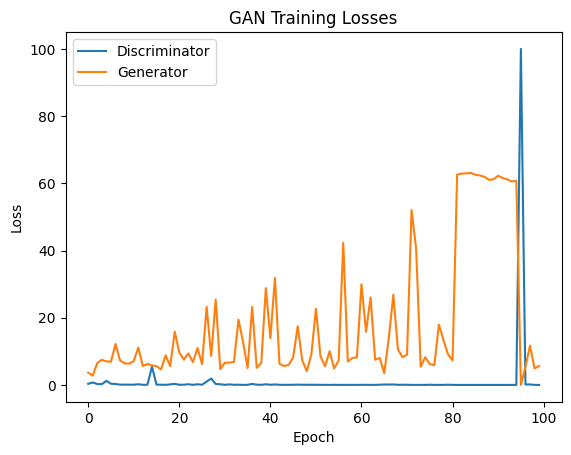

In [39]:
# Plot the discriminator and generator losses over epochs
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('GAN Training Losses')


Text(0.5, 1.0, 'Discriminator Scores (Real vs Fake)')

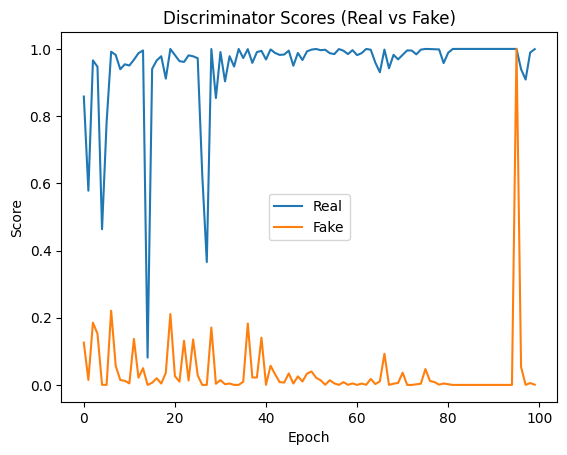

In [40]:
# Plot the real and fake scores over epochs
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend(['Real', 'Fake'])
plt.title('Discriminator Scores (Real vs Fake)')